# Generating Tabular Data via XGBoost Models with Flow-Matching

This notebook is a self-contained example showing how to train the novel Forest-Flow method to generate tabular data. The idea behind Forest-Flow is to learn Flow-Matching's vector field with XGBoost models instead of neural networks. The motivation is that it is known that Forests work currently better than neural networks on Tabular data tasks. This idea comes with some difficulties, for instance how to approximate Flow Matching's loss, and this notebook shows how to do it on a minimal example. The method, its training procedure and the experiments are described in [(Jolicoeur-Martineau et al. 2023)](https://arxiv.org/abs/2309.09968). The full code can be found [here](https://github.com/SamsungSAILMontreal/ForestDiffusion). 

# Imports

In [1]:
import copy
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import xgboost as xgb
from joblib import Parallel, delayed
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler

from torchcfm.conditional_flow_matching import ConditionalFlowMatcher

In [2]:
# set seed
seed = 1980
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

As example, we use [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set), a classic tabular dataset about flowers with 150 observations, 4 input continuous variables (sepal length, sepal width, petal length, and petal width), and 1 categorical outcome variable (3 categories of flowers; setosa, versicolor, and virginica).

In [3]:
# Iris: numpy dataset with 4 variables (all numerical) and 1 outcome (categorical; 3 categories)
my_data = load_iris()
X, y = my_data["data"], my_data["target"]

# shuffle the observations
new_perm = np.random.permutation(X.shape[0])
np.take(X, new_perm, axis=0, out=X)
np.take(y, new_perm, axis=0, out=y)

# Save data before adding missing values
X_true, y_true = copy.deepcopy(X), copy.deepcopy(y)
Xy_true = np.concatenate((X_true, np.expand_dims(y_true, axis=1)), axis=1)

In [4]:
X[0:10]

array([[6.4, 2.9, 4.3, 1.3],
       [6.3, 2.5, 4.9, 1.5],
       [5. , 3.5, 1.3, 0.3],
       [7.6, 3. , 6.6, 2.1],
       [5.7, 2.6, 3.5, 1. ],
       [6.9, 3.2, 5.7, 2.3],
       [6.4, 3.2, 5.3, 2.3],
       [5.7, 2.8, 4.1, 1.3],
       [4.4, 3. , 1.3, 0.2],
       [5.4, 3.4, 1.5, 0.4]])

In [5]:
y[0:10]

array([1, 1, 0, 2, 1, 2, 2, 1, 0, 0])

We set the hyperparameters here.

In [6]:
# Main hyperparameters
n_t = 50  # number of flow steps (higher is better, 50 is enough for great performance)
duplicate_K = 100  # number of different noise sample per real data sample (higher is better)

# XGBoost hyperparameters
max_depth = 7
n_estimators = 100
eta = 0.3
tree_method = "hist"
reg_lambda = 0.0
reg_alpha = 0.0
subsample = 1.0

We do the data preprocessing, which includes min/max normalization and extracting the $x(t)$, $y$.

In [7]:
# Save min/max of the values
X_min = np.nanmin(X, axis=0, keepdims=1)
X_max = np.nanmax(X, axis=0, keepdims=1)

# Min-Max scaling of the variables
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

# Save shape
b, c = X.shape

# we duplicate the data multiple times, so that X0 is k times bigger, so that we can have k random noise z associated per sample
X1 = np.tile(X_scaled, (duplicate_K, 1))

# Generate noise data
X0 = np.random.normal(size=X1.shape)

# Saving the freqency of the classes and storing label masks for later
y_uniques, y_probs = np.unique(y, return_counts=True)
y_probs = y_probs / np.sum(y_probs)
mask_y = {}  # mask for which observations has a specific value of y
for i in range(len(y_uniques)):
    mask_y[y_uniques[i]] = np.zeros(b, dtype=bool)
    mask_y[y_uniques[i]][y == y_uniques[i]] = True
    mask_y[y_uniques[i]] = np.tile(mask_y[y_uniques[i]], (duplicate_K))
n_y = len(y_uniques)  # number of classes

In [8]:
# Build [X(t), y] at multiple values of t

# Define Independent Conditional Flow Matching (I-CFM)
FM = ConditionalFlowMatcher(sigma=0.0)

# Time levels
t_levels = np.linspace(1e-3, 1, num=n_t)

# Interpolation between x0 and x1 (xt)
X_train = np.zeros((n_t, X0.shape[0], X0.shape[1]))  # [n_t, b, c]

# Output to predict (ut)
y_train = np.zeros((n_t, X0.shape[0], X0.shape[1]))  # [n_t, b, c]

# Fill with xt and ut
for i in range(n_t):
    t = torch.ones(X0.shape[0]) * t_levels[i]  # current t
    _, xt, ut = FM.sample_location_and_conditional_flow(
        torch.from_numpy(X0), torch.from_numpy(X1), t=t
    )
    X_train[i], y_train[i] = xt.numpy(), ut.numpy()

We train the $ckn_t$ XGBoost models, where $k$ is the number of classes (3), $c$ is the number of input variables (4), and $n_t$ is the number of time levels (50) .

In [9]:
# Function used for training one model


def train_parallel(X_train, y_train):
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        objective="reg:squarederror",
        eta=eta,
        max_depth=max_depth,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        seed=666,
        tree_method=tree_method,
        device="cpu",
    )

    y_no_miss = ~np.isnan(y_train)
    model.fit(X_train[y_no_miss, :], y_train[y_no_miss])

    return model

In [10]:
%%time
# Train all model(s); fast if you have a decent multi-core CPU, but extremely slow on Google Colab because it uses a weak 2-core CPU


regr = Parallel(n_jobs=-1)(  # using all cpus
    delayed(train_parallel)(
        X_train.reshape(n_t, b * duplicate_K, c)[i][mask_y[j], :],
        y_train.reshape(n_t, b * duplicate_K, c)[i][mask_y[j], k],
    )
    for i in range(n_t)
    for j in y_uniques
    for k in range(c)
)

# Replace fits with doubly loops to make things easier
regr_ = [[[None for k in range(c)] for i in range(n_t)] for j in y_uniques]
current_i = 0
for i in range(n_t):
    for j in range(len(y_uniques)):
        for k in range(c):
            regr_[j][i][k] = regr[current_i]
            current_i += 1
regr = regr_

CPU times: user 4.27 s, sys: 1.82 s, total: 6.09 s
Wall time: 10.4 s


We generate data by solving the ODE.

In [11]:
batch_size = 150  # number of generated samples

In [12]:
# Return the flow at time t using the XGBoost models


def my_model(t, xt, mask_y=None):
    # xt is [b*c]
    xt = xt.reshape(xt.shape[0] // c, c)  # [b, c]

    # Output from the models
    out = np.zeros(xt.shape)  # [b, c]
    i = int(round(t * (n_t - 1)))
    for j, label in enumerate(y_uniques):
        for k in range(c):
            out[mask_y[label], k] = regr[j][i][k].predict(xt[mask_y[label], :])

    out = out.reshape(-1)  # [b*c]
    return out

In [13]:
# Simple Euler ODE solver (nothing fancy)


def euler_solve(x0, my_model, N=100):
    h = 1 / (N - 1)
    x_fake = x0
    t = 0
    # from t=0 to t=1
    for i in range(N - 1):
        x_fake = x_fake + h * my_model(t=t, xt=x_fake)
        t = t + h
    return x_fake

In [14]:
# Generate prior noise
x0 = np.random.normal(size=(batch_size, c))

# Generate random labels for the outcome
label_y_fake = y_uniques[np.argmax(np.random.multinomial(1, y_probs, size=x0.shape[0]), axis=1)]
mask_y_fake = {}  # mask for which observations has a specific value of y
for i in range(len(y_uniques)):
    mask_y_fake[y_uniques[i]] = np.zeros(x0.shape[0], dtype=bool)
    mask_y_fake[y_uniques[i]][label_y_fake == y_uniques[i]] = True

# ODE solve
ode_solved = euler_solve(
    my_model=partial(my_model, mask_y=mask_y_fake), x0=x0.reshape(-1), N=n_t
)  # [t, b*c]
solution = ode_solved.reshape(batch_size, c)  # [b, c]

# invert the min-max normalization
solution = scaler.inverse_transform(solution)

# clip to min/max values
small = (solution < X_min).astype(float)
solution = small * X_min + (1 - small) * solution
big = (solution > X_max).astype(float)
solution = big * X_max + (1 - big) * solution

# Concatenate the y label
Xy_fake = np.concatenate((solution, np.expand_dims(label_y_fake, axis=1)), axis=1)

We just generated fake tabular data! Lets now compare the two dataset (real vs fake).

In [15]:
Xy_true[0:10]  # Real data

array([[6.4, 2.9, 4.3, 1.3, 1. ],
       [6.3, 2.5, 4.9, 1.5, 1. ],
       [5. , 3.5, 1.3, 0.3, 0. ],
       [7.6, 3. , 6.6, 2.1, 2. ],
       [5.7, 2.6, 3.5, 1. , 1. ],
       [6.9, 3.2, 5.7, 2.3, 2. ],
       [6.4, 3.2, 5.3, 2.3, 2. ],
       [5.7, 2.8, 4.1, 1.3, 1. ],
       [4.4, 3. , 1.3, 0.2, 0. ],
       [5.4, 3.4, 1.5, 0.4, 0. ]])

In [16]:
Xy_fake[0:10]  # Flow generated data

array([[5.98631354, 2.70193138, 4.65867317, 1.19586857, 1.        ],
       [5.74409306, 2.50085168, 5.09530475, 2.25178491, 2.        ],
       [6.73807458, 3.02723934, 5.38495621, 2.05042391, 2.        ],
       [6.38365676, 2.91431543, 5.74605444, 2.19531052, 2.        ],
       [5.019457  , 3.60030362, 1.40577746, 0.19351193, 0.        ],
       [5.68787654, 2.90044269, 4.15852277, 1.298309  , 1.        ],
       [6.98276689, 3.18978173, 5.77776862, 2.09860239, 2.        ],
       [5.10127287, 3.80102575, 1.55116821, 0.19748871, 0.        ],
       [5.669288  , 2.80610403, 4.0720058 , 1.29987691, 1.        ],
       [4.95260976, 3.19941354, 1.37698165, 0.2002001 , 0.        ]])

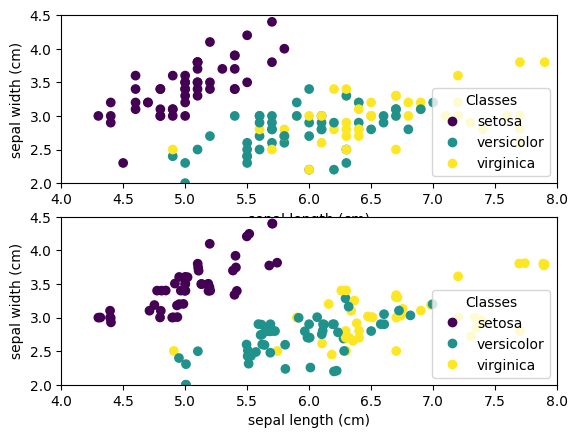

In [17]:
_, (ax1, ax2) = plt.subplots(2)
# Real data
scatter = ax1.scatter(Xy_true[:, 0], Xy_true[:, 1], c=Xy_true[:, -1])
ax1.set(
    xlabel=my_data.feature_names[0], ylabel=my_data.feature_names[1], xlim=(4, 8), ylim=(2, 4.5)
)
_ = ax1.legend(
    scatter.legend_elements()[0], my_data.target_names, loc="lower right", title="Classes"
)
# Fake data
scatter = ax2.scatter(Xy_fake[:, 0], Xy_fake[:, 1], c=Xy_fake[:, -1])
ax2.set(
    xlabel=my_data.feature_names[0], ylabel=my_data.feature_names[1], xlim=(4, 8), ylim=(2, 4.5)
)
_ = ax2.legend(
    scatter.legend_elements()[0], my_data.target_names, loc="lower right", title="Classes"
)

Below we show how to do the same with the [ForestDiffusion pip package](https://github.com/SamsungSAILMontreal/ForestDiffusion).

In [18]:
%%time
from ForestDiffusion import ForestDiffusionModel as ForestFlowModel

forest_model = ForestFlowModel(
    X,
    label_y=y,
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],
    cat_indexes=[],
    int_indexes=[],
    diffusion_type="flow",
    n_jobs=-1,
    seed=1,
)
Xy_fake_ = forest_model.generate(batch_size=X.shape[0])

CPU times: user 2.84 s, sys: 5.15 s, total: 8 s
Wall time: 11.6 s


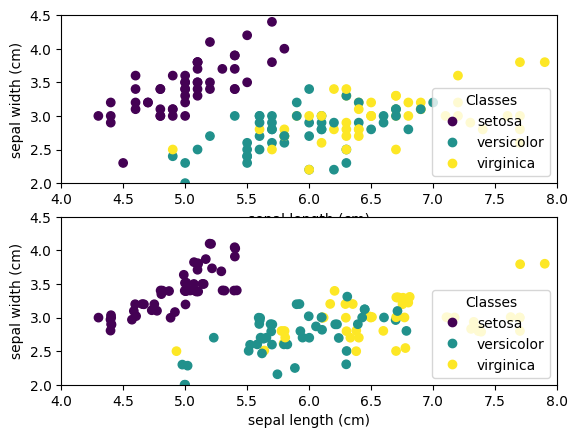

In [19]:
_, (ax1, ax2) = plt.subplots(2)
# Real data
scatter = ax1.scatter(Xy_true[:, 0], Xy_true[:, 1], c=Xy_true[:, -1])
ax1.set(
    xlabel=my_data.feature_names[0], ylabel=my_data.feature_names[1], xlim=(4, 8), ylim=(2, 4.5)
)
_ = ax1.legend(
    scatter.legend_elements()[0], my_data.target_names, loc="lower right", title="Classes"
)
# Fake data
scatter = ax2.scatter(Xy_fake_[:, 0], Xy_fake_[:, 1], c=Xy_fake_[:, -1])
ax2.set(
    xlabel=my_data.feature_names[0], ylabel=my_data.feature_names[1], xlim=(4, 8), ylim=(2, 4.5)
)
_ = ax2.legend(
    scatter.legend_elements()[0], my_data.target_names, loc="lower right", title="Classes"
)